# Scalable image search with vocabulary trees

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import data
from skimage import io
from skimage import color
from skimage.transform import rescale, resize, downscale_local_mean
import scipy.ndimage as ndimg
import cv2
import cv2.xfeatures2d as f2d
import random
import os

In [2]:
from main import *
from VocabTree import *

Invalid name, skipping:  .DS_Store
Invalid name, skipping:  .ipynb_checkpoints


## Keypoint detection

In [3]:
shrek = io.imread("DVDcovers/shrek2.jpg")
incred = io.imread("DVDcovers/the_incredibles.jpg")
matrix = io.imread("DVDcovers/matrix.jpg")
toys = io.imread("DVDcovers/toy_story.jpg")

In [4]:
toys_test = io.imread("test/image_04.jpeg")
incred_test = io.imread("test/image_05.jpeg")
shrek_test = io.imread("test/image_01.jpeg")
matrix_test = io.imread("test/image_07.jpeg")

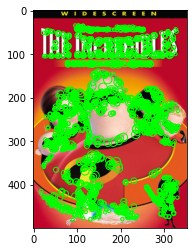

In [5]:
visualize_keypoints(incred, algo='BRISK', clr='lime')

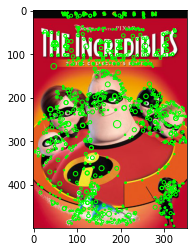

In [6]:
visualize_keypoints(incred, algo='SIFT', clr='lime')

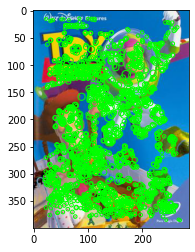

In [7]:
visualize_keypoints(toys, algo='BRISK', clr='lime')

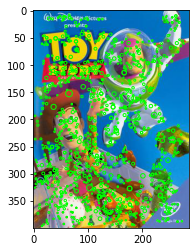

In [8]:
visualize_keypoints(toys, algo='SIFT', clr='lime')

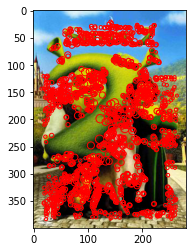

In [9]:
visualize_keypoints(shrek, algo='BRISK', clr='r')

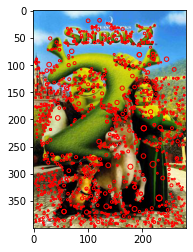

In [10]:
visualize_keypoints(shrek, algo='SIFT', clr='r')

## Homography estimation

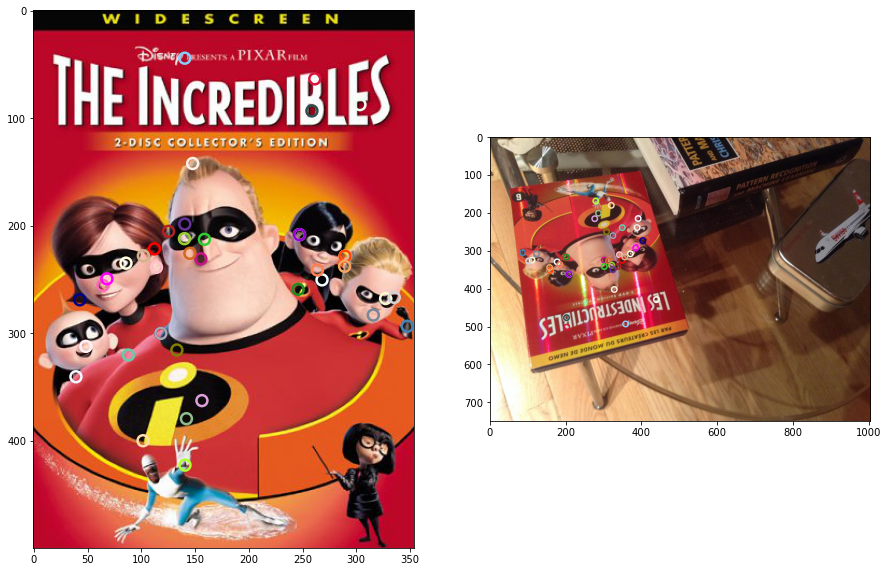

In [11]:
incred_matches = match_keypoints(incred, incred_test, algo='SIFT', thresh=.45)
incred_matches = get_best_n(incred_matches, 50)
draw_matches(incred, incred_test, incred_matches, size=(15,30))

In [12]:
Hi = RANSAC_fit_homography(incred_matches)
warped = cv2.warpPerspective(incred, Hi, (1000,750))
corners = [(0, 0), (0, incred.shape[0]), (incred.shape[1], 0), (incred.shape[1], incred.shape[0])]

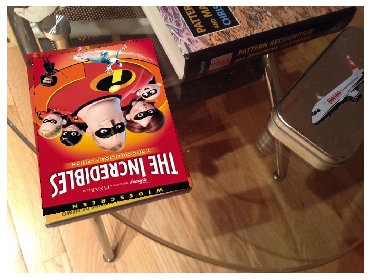

In [13]:
superpose_image(warped, incred_test.copy())

## Efficient retrieval

### Catalog features for all the images in the database

In [14]:
def build_feature_db(path):
    features = []
    os.chdir('/Users/harma/Desktop/CSC420/p/')
    os.chdir(path)
    db = {}
    for imgname in os.listdir('.'):
        try:
            img = io.imread(imgname)
        except:
            print("Invalid name, skipping: ", imgname)
        kps, desc = get_SIFT_descriptors(img.copy())
        #desc = get_best_n_descs(kps, desc, 100)
        db[imgname] = (kps, desc)
        temps_desc = []
        for row in desc:
            features.append(list(row))
    os.chdir('/Users/harma/Desktop/CSC420/p/')
    return db, np.array(features)

In [15]:
imgdb, features = build_feature_db('./DVDcovers')

Invalid name, skipping:  .DS_Store
Invalid name, skipping:  .ipynb_checkpoints


In [16]:
features.shape

(271629, 128)

### Building the vocabulary tree 

In [17]:
kmeans = MiniBatchKMeans
vt = VocabTree(4, 10, kmeans, features, 0)

In [18]:
vt.build_tree(features)

### Computing the test images' code vectors

In [19]:
str(vt.compute_path(incred_test))[:1000]

'{37968: 559, 44645: 63, 44646: 23, 46483: 11, 46823: 9, 46824: 4, 46851: 3, 46853: 2, 46861: 1, 0: 917, 11824: 547, 16950: 238, 19202: 101, 19660: 12, 19661: 3, 19662: 2, 19682: 1, 19689: 1, 19690: 1, 1: 179, 2: 53, 1783: 19, 2264: 11, 2265: 1, 2301: 1, 2309: 1, 2314: 1, 30732: 166, 33579: 109, 35463: 37, 35745: 25, 35885: 7, 35895: 5, 35896: 3, 35899: 3, 47240: 23, 49349: 7, 49758: 3, 49911: 2, 49912: 2, 49917: 2, 49922: 1, 69383: 323, 70420: 87, 72803: 23, 73082: 6, 73102: 4, 73103: 3, 73108: 3, 73109: 2, 73110: 1, 73397: 24, 74137: 14, 74215: 5, 74251: 1, 74252: 1, 74253: 1, 22673: 80, 24676: 60, 24677: 11, 24916: 4, 24945: 2, 24947: 2, 146402: 1070, 185227: 257, 185228: 51, 185232: 21, 185402: 14, 185403: 2, 185429: 1, 185433: 1, 185435: 1, 50198: 9, 50687: 9, 51023: 3, 51078: 3, 51079: 1, 51095: 1, 51097: 1, 48290: 4, 48820: 2, 48831: 2, 48941: 1, 48977: 1, 48984: 1, 36475: 25, 37412: 15, 37417: 9, 37459: 7, 37567: 4, 37587: 4, 37600: 3, 37601: 3, 37605: 1, 73113: 1, 146403: 396,

In [20]:
code_incred_t = vt.compute_img_code(incred_test)
code_sh = vt.compute_img_code(shrek_test)
code_mx = vt.compute_img_code(matrix_test)

In [21]:
code_incred_t

array([-5083.73743971,  -726.20099085,  -154.50654109, ...,
           0.        ,     0.        ,     0.        ])

In [22]:
np.array([x for x in code_incred_t if x != 0])

array([-5.08373744e+03, -7.26200991e+02, -1.54506541e+02, ...,
        1.02585293e+00,  2.32163329e+00,  2.87167962e+00])

In [23]:
np.array([x for x in code_incred_t if x != 0]).shape

(8742,)

### Retrieve 10 images with closest representation to test image

In [24]:
imgmap = {}
for img in os.listdir('./DVDcovers/'):
    imgname = './DVDcovers/' + img
    try:
        im = io.imread(imgname)
    except:
        continue
    x = (vt.imgdb[imgname])
    r = cos_sim(x, code_incred_t)
    imgmap[r] = imgmap.setdefault(r, []) + [imgname]

In [25]:
imgmap[max(imgmap.keys())], max(imgmap.keys())

(['./DVDcovers/the_incredibles.jpg'], 0.9891595340581546)

In [26]:
cos_sim(code_incred_t, (vt.imgdb['./DVDcovers/the_incredibles.jpg']))

0.9891595340581546

In [27]:
for u in sorted(imgmap)[::-1][:10]:
    print(imgmap[u])

['./DVDcovers/the_incredibles.jpg']
['./DVDcovers/the_factory.jpg']
['./DVDcovers/argo.jpg']
['./DVDcovers/non_stop.jpg']
['./DVDcovers/reservoir_dogs.jpg']
['./DVDcovers/10_things_i_hate_about_you.jpg']
['./DVDcovers/the_santa_clause.jpg']
['./DVDcovers/the_last_stand.jpg']
['./DVDcovers/matrix.jpg']
['./DVDcovers/the_good_wife_season_3.jpg']


In [28]:
matches = [imgmap[u][0] for u in sorted(imgmap)[::-1][:10]]

In [29]:
matches

['./DVDcovers/the_incredibles.jpg',
 './DVDcovers/the_factory.jpg',
 './DVDcovers/argo.jpg',
 './DVDcovers/non_stop.jpg',
 './DVDcovers/reservoir_dogs.jpg',
 './DVDcovers/10_things_i_hate_about_you.jpg',
 './DVDcovers/the_santa_clause.jpg',
 './DVDcovers/the_last_stand.jpg',
 './DVDcovers/matrix.jpg',
 './DVDcovers/the_good_wife_season_3.jpg']

In [30]:
imgmap = {}
for img in os.listdir('./DVDcovers/'):
    imgname = './DVDcovers/' + img
    try:
        im = io.imread(imgname)
    except:
        continue
    x = (vt.imgdb[imgname])
    r = cos_sim(x, code_mx)
    imgmap[r] = imgmap.setdefault(r, []) + [imgname]
    
for u in sorted(imgmap)[::-1][:10]:
    print(imgmap[u])

['./DVDcovers/always.jpg']
['./DVDcovers/matrix.jpg']
['./DVDcovers/outlander.jpg']
['./DVDcovers/man_of_steel.jpg']
['./DVDcovers/the_sum_of_all_fears.jpg']
['./DVDcovers/reservoir_dogs.jpg']
['./DVDcovers/legends_of_the_fall.jpg']
['./DVDcovers/the_grey.jpg']
['./DVDcovers/sommersby.jpg']
['./DVDcovers/supernatural.jpg']


In [31]:
cos_sim(code_mx, (vt.imgdb['./DVDcovers/matrix.jpg']))

0.9843812305385865

### Compute homographies for the top 10 with RANSAC

In [32]:
warps, Hs, inliers = compute_results_homographies(matches, incred_test)

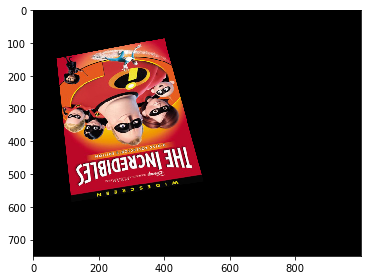

In [33]:
io.imshow(warps[0])

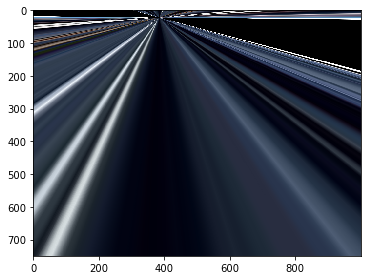

In [34]:
io.imshow(warps[1])

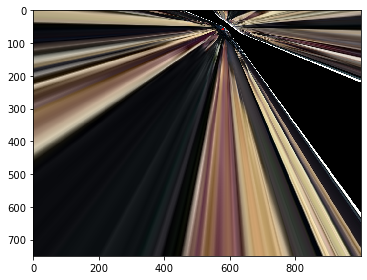

In [35]:
io.imshow(warps[2])

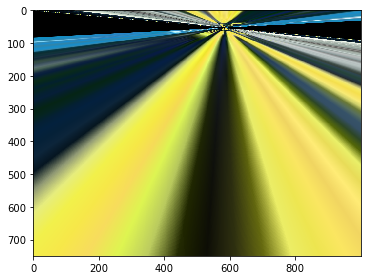

In [36]:
io.imshow(warps[3])

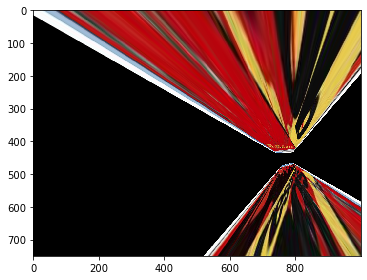

In [37]:
io.imshow(warps[4])

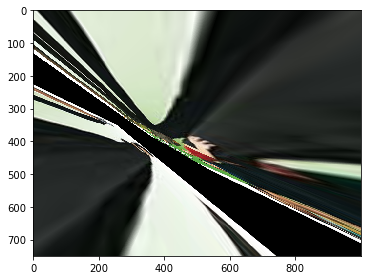

In [38]:
io.imshow(warps[5])

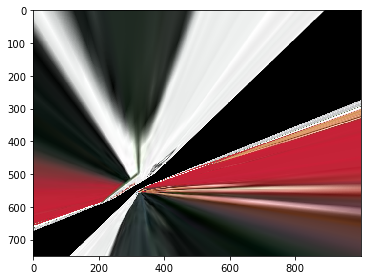

In [39]:
io.imshow(warps[6])

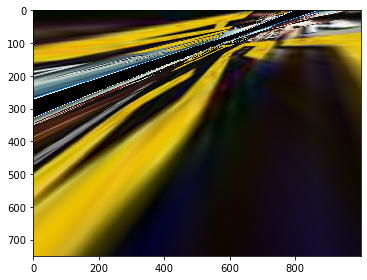

In [40]:
io.imshow(warps[7])

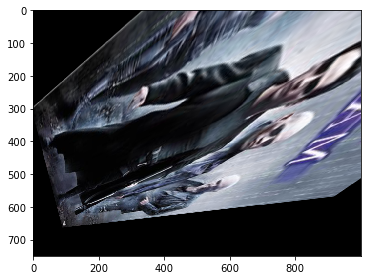

In [41]:
io.imshow(warps[8])

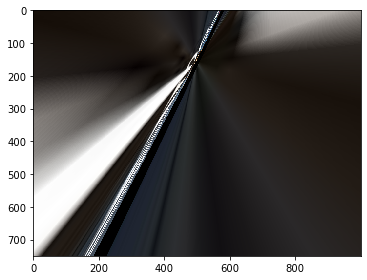

In [42]:
io.imshow(warps[9])

In [43]:
num_inliers = [(len(inliers[k]), k) for k in inliers.keys()]
num_inliers

[(96, './DVDcovers/the_incredibles.jpg'),
 (7, './DVDcovers/the_factory.jpg'),
 (7, './DVDcovers/argo.jpg'),
 (8, './DVDcovers/non_stop.jpg'),
 (7, './DVDcovers/reservoir_dogs.jpg'),
 (7, './DVDcovers/10_things_i_hate_about_you.jpg'),
 (8, './DVDcovers/the_santa_clause.jpg'),
 (7, './DVDcovers/the_last_stand.jpg'),
 (8, './DVDcovers/matrix.jpg'),
 (6, './DVDcovers/the_good_wife_season_3.jpg')]

In [44]:
max_inliers = max(num_inliers)
max_inliers

(96, './DVDcovers/the_incredibles.jpg')